## Import

In [1]:
from pyspark import SparkConf, SparkContext
import pyspark
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

# Mapper

## Tofloat

* 因為計算方便，所以用Mapper先把數字都從string換成float

In [2]:
def Tofloat(line):
    for i in range(len(line)):
        line[i] = float(line[i])
    return line

## Mapper_Euclidean_C1

* 每個line是傳進來的點
* 這裏找出離該點最近的centroid
* 用c1當初始的中心，距離用Euclidean
* 公式是:該點到每個中心的距離的平方開根號
* 因為找出最近的點，這裏省略開根號不會影響遠近

In [3]:
def Mapper_Euclidean_C1(line):
    
    dist = []
    for i in range(10):
        diff = 0.0
        for j in range(58):
            diff += (line[j] - centroids_c1[i][1][j])*(line[j] - centroids_c1[i][1][j])

        dist.append( diff )
    mini = dist.index(min(dist))
  
    return (mini, line)  

## Mapper_Euclidean_C2

* 每個line是傳進來的點
* 這裏找出離該點最近的centroid
* 用c2當初始的中心，距離用Euclidean

In [4]:
def Mapper_Euclidean_C2(line):
    
    dist = []
    for i in range(10):
        diff = 0.0
        for j in range(58):
            diff += (line[j] - centroids_c2[i][1][j])*(line[j] - centroids_c2[i][1][j])

        dist.append( diff )
    mini = dist.index(min(dist))
            
    return (mini, line)

## Mapper_Manhattan_C1

* 每個line是傳進來的點
* 這裏找出離該點最近的centroid
* 用c1當初始的中心，距離用Manhattan
* 公式是:該點到每個中心的距離的絕對值

In [5]:
def Mapper_Manhattan_C1(line):
    dist = []
    
    for i in range(10):
        diff = 0.0
        for j in range(58):
            diff += abs(line[j] - centroids_c1_Manhattan[i][1][j])
            
        dist.append(diff)
    mini = dist.index(min(dist))
    
    return (mini, line)

## Mapper_Manhattan_C2

* 每個line是傳進來的點
* 這裏找出離該點最近的centroid
* 用c2當初始的中心，距離用Manhattan
* 公式是:該點到每個中心的距離的絕對值

In [6]:
def Mapper_Manhattan_C2(line):
    dist = []
    
    for i in range(10):
        diff = 0.0
        for j in range(58):
            diff += abs(line[j] - centroids_c2_Manhattan[i][1][j])
            
        dist.append(diff)
    mini = dist.index(min(dist))
    
    return (mini, line)

## Update

* 傳進來的line是 **( cluster, [ 點1, 點2, ,,, ] )**
* 這裏更新每個cluster的中心
* 中心的算法是每個點的平均值

In [7]:
def Update(line):
    newline = []
        
    for i in range(len(line[1][0])):
        Sum = 0.0
        for j in range(len(line[1])):
            Sum += line[1][j][i]
        newline.append( Sum/len(line[1]) )
        
    return (line[0], newline)

## Cost_Euclidean_C1

* 傳進來的line是 **( cluster, [ 點1, 點2, ,,, ] )**
* 這裏算出每個點到中心的Euclidean距離後再加總
* 用c1當初始的中心

In [8]:
def Cost_Euclidean_C1(line):
    cost = 0
    for i in range(len(line[1])):
        for j in range(len(line[1][i])):
            cost += (line[1][i][j]-centroids_c1[ line[0] ][1][j])*(line[1][i][j]-centroids_c1[ line[0] ][1][j])
    return (line[0], cost)

## Cost_Euclidean_C2

* 傳進來的line是 **( cluster, [ 點1, 點2, ,,, ] )**
* 這裏算出每個點到中心的Euclidean距離後再加總
* 用c2當初始的中心

In [9]:
def Cost_Euclidean_C2(line):
    cost = 0
    for i in range(len(line[1])):
        for j in range(len(line[1][i])):
            cost += (line[1][i][j]-centroids_c2[ line[0] ][1][j])*(line[1][i][j]-centroids_c2[ line[0] ][1][j])
    return (line[0], cost)

## Cost_Manhattan_C1

* 傳進來的line是 **( cluster, [ 點1, 點2, ,,, ] )**
* 這裏算出每個點到中心的Manhattan距離後再加總
* 用c1當初始的中心

In [10]:
def Cost_Manhattan_C1(line):
    cost = 0
    for i in range(len(line[1])):
        for j in range(len(line[1][i])):
            cost += abs(line[1][i][j]-centroids_c1_Manhattan[ line[0] ][1][j])
    return (line[0], cost)

## Cost_Manhattan_C2

* 傳進來的line是 **( cluster, [ 點1, 點2, ,,, ] )**
* 這裏算出每個點到中心的Manhattan距離後再加總
* 用c2當初始的中心

In [11]:
def Cost_Manhattan_C2(line):
    cost = 0
    for i in range(len(line[1])):
        for j in range(len(line[1][i])):
            cost += abs(line[1][i][j]-centroids_c2_Manhattan[ line[0] ][1][j])
    return (line[0], cost)

## 宣告spark並且讀取資料

In [12]:
conf = SparkConf().set("spark.default.parallelism", 4).setAppName("KMeans")
sc = SparkContext(conf=conf)
c1 = sc.textFile("./c1.txt").map(lambda line : line.split(' ')).map(Tofloat)
C1 = c1.collect()
#print(C1)
c2 = sc.textFile("./c2.txt").map(lambda line : line.split(' ')).map(Tofloat)
C2 = c2.collect()
data = sc.textFile("./data.txt").map(lambda line : line.split(' ')).map(Tofloat)
DATA = data.collect()

## 初始化每個方法對於c1、c2的中心

In [13]:
centroids_c1 = []
centroids_c1_Manhattan = []
for i in range(len(C1)):
    centroids_c1.append( (i, C1[i]) )
    centroids_c1_Manhattan.append( (i, C1[i]) )

In [14]:
centroids_c2 = []
centroids_c2_Manhattan = []
for i in range(len(C2)):
    centroids_c2.append( (i, C2[i]) )
    centroids_c2_Manhattan.append( (i, C2[i]) )

## c1當中心用Euclidean的方法

* 先把每個點找最近的中心
* 算出每個點的cost
* 更新每個cluster的中心

In [15]:
cost_c1_Euclidean = []
for i in range(20):
    cluster_c1 = data.map(Mapper_Euclidean_C1).groupByKey().mapValues(list)
    cost = cluster_c1.map(Cost_Euclidean_C1).values().sum()
    cost_c1_Euclidean.append(cost)
    updated = cluster_c1.map(Update)
    centroids_c1 = sorted(updated.collect())
#print(centroids_c1)
sorted(updated.collect())

[(0,
  [0.1583985765124556,
   0.13565836298932385,
   0.3429537366548041,
   0.0500355871886121,
   0.328861209964413,
   0.12071174377224195,
   0.09046263345195729,
   0.13758007117437726,
   0.2517081850533807,
   0.3514590747330959,
   0.09017793594306048,
   0.7464768683274025,
   0.12380782918149458,
   0.09775800711743772,
   0.0820996441281139,
   0.2674021352313166,
   0.23736654804270457,
   0.13565836298932382,
   1.4670106761565844,
   0.12049822064056939,
   1.0337010676156593,
   0.32206405693950185,
   0.13992882562277584,
   0.17633451957295368,
   0.7377580071174378,
   0.16800711743772248,
   0.019039145907473312,
   0.015729537366548044,
   0.012455516014234875,
   0.023736654804270462,
   0.010604982206405697,
   0.0020640569395017796,
   0.09491103202846975,
   0.003131672597864769,
   0.021387900355871885,
   0.06861209964412808,
   0.1437366548042704,
   0.012348754448398577,
   0.018540925266903922,
   0.02185053380782918,
   0.047935943060498226,
   0.08366548

## 距離用Euclidean的表格

In [16]:
dic = {}
centroids = sorted(centroids_c1)
for i in range(len(centroids)):
    dist = []
    for j in range(0, i):
        diff = np.array(centroids[i][1]) - np.array(centroids[j][1])
        dist.append(int(math.sqrt(diff.T.dot(diff))))
    remain = len(centroids) - len(dist)
    none = [0] * remain
    dist += none
    dic[centroids[i][0]] = dist
idx = []
for i in range(10):
    idx.append(i)
df = pd.DataFrame(dic, index = idx)
print(df)

   0    1     2     3     4     5     6     7     8     9
0  0  692  3490   205   346   512   444   566  1282   307
1  0    0  2798   897  1038  1204  1136  1257   669   412
2  0    0     0  3695  3836  4002  3934  4056  2294  3195
3  0    0     0     0   142   309   241   363  1474   504
4  0    0     0     0     0   167    99   220  1615   646
5  0    0     0     0     0     0    67    53  1782   814
6  0    0     0     0     0     0     0   121  1715   746
7  0    0     0     0     0     0     0     0  1835   867
8  0    0     0     0     0     0     0     0     0   975
9  0    0     0     0     0     0     0     0     0     0


## 距離用Manhattan的表格

In [17]:
dic = {}
centroids = sorted(centroids_c1)
for i in range(len(centroids)):
    dist = []
    for j in range(0, i):
        diff = np.array(centroids[i][1]) - np.array(centroids[j][1])
        dist.append(int(np.sum(abs(diff))))
    remain = len(centroids) - len(dist)
    none = [0] * remain
    dist += none
    dic[centroids[i][0]] = dist
idx = []
for i in range(10):
    idx.append(i)
df = pd.DataFrame(dic, index = idx)
print(df)

   0    1     2     3     4     5     6     7     8     9
0  0  728  3797   212   374   577   499   645  1731   406
1  0    0  3072   935  1100  1303  1225  1372  1005   490
2  0    0     0  4001  4170  4372  4294  4440  2513  3396
3  0    0     0     0   171   375   296   443  1934   609
4  0    0     0     0     0   204   125   272  2102   779
5  0    0     0     0     0     0    79    69  2306   983
6  0    0     0     0     0     0     0   147  2227   904
7  0    0     0     0     0     0     0     0  2374  1050
8  0    0     0     0     0     0     0     0     0  1327
9  0    0     0     0     0     0     0     0     0     0


## c2當中心用Euclidean的方法

* 先把每個點找最近的中心
* 算出每個點的cost
* 更新每個cluster的中心

In [18]:
cost_c2_Euclidean = []
for i in range(20):
    cluster_c2 = data.map(Mapper_Euclidean_C2).groupByKey().mapValues(list)
    cost = cluster_c2.map(Cost_Euclidean_C2).values().sum()
    cost_c2_Euclidean.append(cost)
    updated = cluster_c2.map(Update)
    centroids_c2 = sorted(updated.collect())

## 距離用Euclidean的表格

In [19]:
dic = {}
centroids = sorted(centroids_c2)
for i in range(len(centroids)):
    dist = []
    for j in range(0, i):
        diff = np.array(centroids[i][1]) - np.array(centroids[j][1])
        dist.append(int(math.sqrt(diff.T.dot(diff))))
    remain = len(centroids) - len(dist)
    none = [0] * remain
    dist += none
    dic[centroids[i][0]] = dist
idx = []
for i in range(10):
    idx.append(i)
df = pd.DataFrame(dic, index = idx)
print(df)

   0      1      2     3      4      5      6      7      8      9
0  0  15760  14110  9045   5567   1924   1100    402   2105   3169
1  0      0  11524  6743  10192  14455  14682  15362  13674  12597
2  0      0      0  9545  10883  12233  13208  13786  12508  11938
3  0      0      0     0   3494   7718   7957   8644   6947   5876
4  0      0      0     0      0   4404   4492   5169   3488   2407
5  0      0      0     0      0      0   1182   1615   1313   2153
6  0      0      0     0      0      0      0    698   1010   2085
7  0      0      0     0      0      0      0      0   1702   2768
8  0      0      0     0      0      0      0      0      0   1080
9  0      0      0     0      0      0      0      0      0      0


## 距離用Manhattan的表格

In [20]:
dic = {}
centroids = sorted(centroids_c2)
for i in range(len(centroids)):
    dist = []
    for j in range(0, i):
        diff = np.array(centroids[i][1]) - np.array(centroids[j][1])
        dist.append(int(np.sum(abs(diff))))
    remain = len(centroids) - len(dist)
    none = [0] * remain
    dist += none
    dic[centroids[i][0]] = dist
idx = []
for i in range(10):
    idx.append(i)
df = pd.DataFrame(dic, index = idx)
print(df)

   0      1      2      3      4      5      6      7      8      9
0  0  15772  20215   9533   5604   3088   1311    471   2369   3349
1  0      0  16003   7219  10221  16105  14909  15434  13950  12776
2  0      0      0  10690  14613  17509  18912  19748  17851  16873
3  0      0      0      0   3935   8896   8228   9065   7168   6190
4  0      0      0      0      0   5893   4696   5221   3737   2564
5  0      0      0      0      0      0   1781   2619   2162   3337
6  0      0      0      0      0      0      0    840   1068   2137
7  0      0      0      0      0      0      0      0   1901   2883
8  0      0      0      0      0      0      0      0      0   1176
9  0      0      0      0      0      0      0      0      0      0


## Precentage improvement value for Euclidean c1

In [21]:
print('%.1f' % (abs(cost_c1_Euclidean[len(cost_c1_Euclidean) - 1] - cost_c1_Euclidean[0]) / cost_c1_Euclidean[0] * 100) + '%.')

26.9%.


## Precentage improvement value for Euclidean c2

In [22]:
print('%.1f' % (abs(cost_c2_Euclidean[len(cost_c2_Euclidean) - 1] - cost_c2_Euclidean[0]) / cost_c2_Euclidean[0] * 100) + '%.')

79.4%.


## Explanation of precentage improvement value for Euclidean 

因為c2的centroid兩兩越遠越好，而data是隨機分布的，所以在一開始data被分配的時候移動的距離會相較c1的大。而c1的centroid跟data一樣是隨機分布的，所以當data被分配到時候移動的距離相對不會那麼大，總結來說因此c2的Precentage improvement會比c1來得大。

## Is random initialization of k-means using c1.txt better than c2.txt in terms of Euclidean cost function?

當用Euclidean的距離來實作k-means時，最小化的是平方和的開根號，也就是兩點之間距離，所以c2是每個centroid兩兩之間越遠的時候，cluster分布比較平均，每個點到該點的centroid的距離會越小，所以c2的cost會小於c1，同時進步的幅度也比較大。

          Random Centroids  Selected Centroids
Round 1       6.236603e+08        4.387478e+08
Round 2       5.098629e+08        2.498039e+08
Round 3       4.854807e+08        1.944948e+08
Round 4       4.639970e+08        1.698048e+08
Round 5       4.609693e+08        1.562957e+08
Round 6       4.605378e+08        1.490942e+08
Round 7       4.603131e+08        1.425085e+08
Round 8       4.600035e+08        1.323039e+08
Round 9       4.595705e+08        1.171710e+08
Round 10      4.590211e+08        1.085474e+08
Round 11      4.584907e+08        1.022372e+08
Round 12      4.579442e+08        9.827802e+07
Round 13      4.575580e+08        9.563023e+07
Round 14      4.572901e+08        9.379331e+07
Round 15      4.570506e+08        9.237713e+07
Round 16      4.568922e+08        9.154161e+07
Round 17      4.567036e+08        9.104557e+07
Round 18      4.564042e+08        9.075224e+07
Round 19      4.561778e+08        9.047017e+07
Round 20      4.559869e+08        9.021642e+07


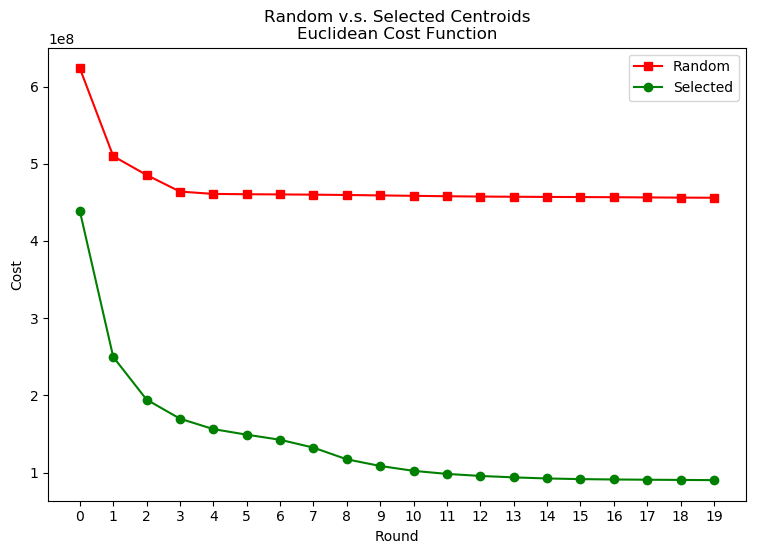

In [23]:
Round = []
for i in range(20):
    Round.append('Round ' + str(i + 1))
    
dic = {'Random Centroids' : cost_c1_Euclidean, 'Selected Centroids' : cost_c2_Euclidean}
df = pd.DataFrame(dic, index = Round)
print(df)

Round = []
for i in range(20):
    Round.append(str(i))
plt.figure(figsize=(9, 6), dpi = 100, linewidth = 2)
plt.plot(Round, cost_c1_Euclidean, 's-', color = 'r', label = "Random")
plt.plot(Round, cost_c2_Euclidean, 'o-', color = 'g', label = "Selected")
plt.title('Random v.s. Selected Centroids\nEuclidean Cost Function')
plt.xlabel('Round')
plt.ylabel('Cost')
plt.legend(loc = 'best')
plt.show()

## c1當中心用Manhattan的方法

* 先把每個點找最近的中心
* 算出每個點的cost
* 更新每個cluster的中心

In [24]:
cost_c1_Manhattan = []
for i in range(20):
    cluster_c1_Manhattan = data.map( Mapper_Manhattan_C1 ).groupByKey().mapValues(list)
    cost = cluster_c1_Manhattan.map(Cost_Manhattan_C1).values().sum()
    cost_c1_Manhattan.append(cost)
    updated = cluster_c1_Manhattan.map( Update )
    centroids_c1_Manhattan = sorted(updated.collect())

## c1當中心用Manhattan的方法

## 距離用Euclidean的表格

In [25]:
dic = {}
centroids = sorted(centroids_c1_Manhattan)
for i in range(len(centroids)):
    dist = []
    for j in range(0, i):
        diff = np.array(centroids[i][1]) - np.array(centroids[j][1])
        dist.append(int(math.sqrt(diff.T.dot(diff))))
    remain = len(centroids) - len(dist)
    none = [0] * remain
    dist += none
    dic[centroids[i][0]] = dist
idx = []
for i in range(10):
    idx.append(i)
df = pd.DataFrame(dic, index = idx)
print(df)

   0     1     2      3      4      5      6      7     8     9
0  0  2219  9948    528    413    827    681    917   832   729
1  0     0  7767   2734   2628   3044   2898   3133  1812  1491
2  0     0     0  10433  10361  10773  10626  10862  9340  9236
3  0     0     0      0    221    375    249    457  1156  1251
4  0     0     0      0      0    415    270    505  1171  1137
5  0     0     0      0      0      0    147     89  1529  1553
6  0     0     0      0      0      0      0    236  1391  1407
7  0     0     0      0      0      0      0      0  1613  1642
8  0     0     0      0      0      0      0      0     0   709
9  0     0     0      0      0      0      0      0     0     0


## c1當中心用Manhattan的方法

## 距離用Manhattan的表格

In [26]:
dic = {}
centroids = sorted(centroids_c1_Manhattan)
for i in range(len(centroids)):
    dist = []
    for j in range(0, i):
        diff = np.array(centroids[i][1]) - np.array(centroids[j][1])
        dist.append(int(np.sum(abs(diff))))
    remain = len(centroids) - len(dist)
    none = [0] * remain
    dist += none
    dic[centroids[i][0]] = dist
idx = []
for i in range(10):
    idx.append(i)
df = pd.DataFrame(dic, index = idx)
print(df)

   0     1      2      3      4      5      6      7      8      9
0  0  2341  11929    651    496    947    770   1056   1260    737
1  0     0   9597   2778   2830   3280   3104   3388   2380   1605
2  0     0      0  12323  12421  12871  12695  12979  10775  11196
3  0     0      0      0    335    558    382    667   1653   1379
4  0     0      0      0      0    452    276    561   1755   1226
5  0     0      0      0      0      0    177    110   2205   1677
6  0     0      0      0      0      0      0    287   2028   1500
7  0     0      0      0      0      0      0      0   2314   1786
8  0     0      0      0      0      0      0      0      0   1006
9  0     0      0      0      0      0      0      0      0      0


## c2當中心用Manhattan的方法

* 先把每個點找最近的中心
* 算出每個點的cost
* 更新每個cluster的中心

In [27]:
cost_c2_Manhattan = []
for i in range(20):
    cluster_c2_Manhattan = data.map( Mapper_Manhattan_C2 ).groupByKey().mapValues(list)
    cost = cluster_c2_Manhattan.map(Cost_Manhattan_C2).values().sum()
    cost_c2_Manhattan.append(cost)
    updated = cluster_c2_Manhattan.map( Update )
    centroids_c2_Manhattan = sorted(updated.collect())

## 距離用Euclidean的表格

In [28]:
dic = {}
centroids = sorted(centroids_c2_Manhattan)
for i in range(len(centroids)):
    dist = []
    for j in range(0, i):
        diff = np.array(centroids[i][1]) - np.array(centroids[j][1])
        dist.append(int(math.sqrt(diff.T.dot(diff))))
    remain = len(centroids) - len(dist)
    none = [0] * remain
    dist += none
    dic[centroids[i][0]] = dist
idx = []
for i in range(10):
    idx.append(i + 1)
df = pd.DataFrame(dic, index = idx)
print(df)

    0      1      2     3      4      5      6      7      8      9
1   0  15747  14100  9032   5554   2006   1338    514   1571   3022
2   0      0  11524  6743  10192  14474  14412  15239  14328  12731
3   0      0      0  9545  10883  12167  13125  13684  12643  12006
4   0      0      0     0   3494   7742   7694   8521   7588   6009
5   0      0      0     0      0   4452   4219   5047   4167   2542
6   0      0      0     0      0      0   1405   1637    910   2124
7   0      0      0     0      0      0      0    827    566   1684
8   0      0      0     0      0      0      0      0   1081   2511
9   0      0      0     0      0      0      0      0      0   1649
10  0      0      0     0      0      0      0      0      0      0


## 距離用Manhattan的表格

In [29]:
dic = {}
centroids = sorted(centroids_c2_Manhattan)
for i in range(len(centroids)):
    dist = []
    for j in range(0, i):
        diff = np.array(centroids[i][1]) - np.array(centroids[j][1])
        dist.append(int(np.sum(abs(diff))))
    remain = len(centroids) - len(dist)
    none = [0] * remain
    dist += none
    dic[centroids[i][0]] = dist
idx = []
for i in range(10):
    idx.append(i + 1)
df = pd.DataFrame(dic, index = idx)
print(df)

    0      1      2      3      4      5      6      7      8      9
1   0  15757  20200   9517   5588   3281   1430    602   2102   3211
2   0      0  16003   7219  10221  16325  14506  15335  14980  12922
3   0      0      0  10690  14613  17521  18775  19602  18111  16995
4   0      0      0      0   3935   9116   8090   8918   7771   6312
5   0      0      0      0      0   6110   4293   5123   4768   2710
6   0      0      0      0      0      0   1855   2682   1358   3413
7   0      0      0      0      0      0      0    833    674   1784
8   0      0      0      0      0      0      0      0   1500   2613
9   0      0      0      0      0      0      0      0      0   2062
10  0      0      0      0      0      0      0      0      0      0


## Precentage improvement value for Manhattan c1

In [30]:
print('%.1f' % (abs(cost_c1_Manhattan[len(cost_c1_Manhattan) - 1] - cost_c1_Manhattan[0]) / cost_c1_Manhattan[0] * 100) + '%.')

18.4%.


## Precentage improvement value for Manhattan c2

In [31]:
print('%.1f' % (abs(cost_c2_Manhattan[len(cost_c2_Manhattan) - 1] - cost_c2_Manhattan[0]) / cost_c2_Manhattan[0] * 100) + '%.')

54.7%.


## Explanation of precentage improvement value for Manhattan

同上，因為c2的centroid兩兩越遠越好，而data是隨機分布的，所以在一開始data被分配的時候移動的距離會相較c1的大。而c1的centroid跟data一樣是隨機分布的，所以當data被分配到時候移動的距離相對不會那麼大，總結來說因此c2的Precentage improvement會比c1來得大。

## Is random initialization of k-means using c1.txt better than c2.txt in terms of Manhattan cost function?

當用Manhattan的距離來實作k-means的時候，最小化的是每個維度的距離的總和，而因為c2是每個centroid兩兩之間距離最遠，是平方和的總和最小，而不是每個維度的距離最小，所以每個點到該點的centroid的每個維度的距離的總和不一定會比較小，不過c2的進步還是比較大。

          Random Centroids  Selected Centroids
Round 1      550117.142000        1.433739e+06
Round 2      464869.275879        1.084489e+06
Round 3      470897.382277        9.734317e+05
Round 4      483914.409173        8.959346e+05
Round 5      489216.071003        8.651283e+05
Round 6      487629.668550        8.458466e+05
Round 7      483711.923214        8.272196e+05
Round 8      475330.773493        8.035903e+05
Round 9      474871.238846        7.560395e+05
Round 10     457232.920115        7.173329e+05
Round 11     447494.386197        6.945879e+05
Round 12     450915.012577        6.844445e+05
Round 13     451250.367073        6.745747e+05
Round 14     451974.595540        6.674095e+05
Round 15     451570.364070        6.635566e+05
Round 16     452739.011366        6.601628e+05
Round 17     453082.730287        6.560413e+05
Round 18     450583.670860        6.530368e+05
Round 19     450368.749317        6.511124e+05
Round 20     449011.363726        6.496890e+05


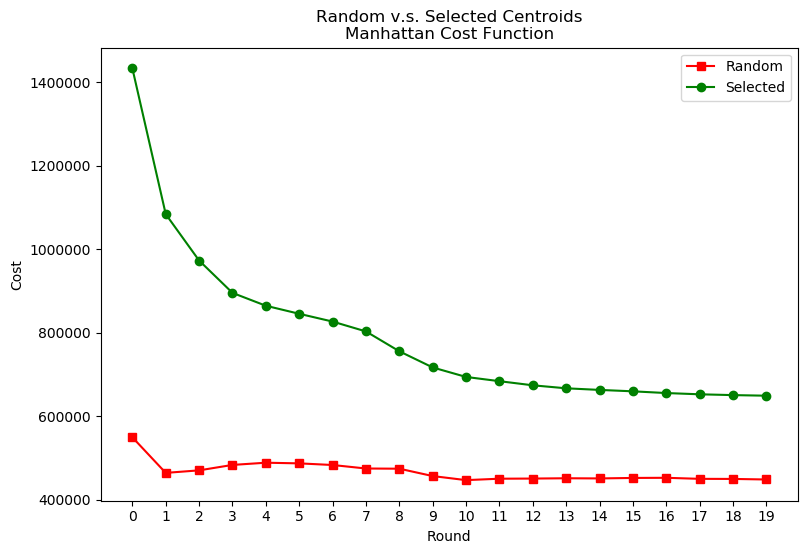

In [32]:
Round = []

for i in range(20):
    Round.append('Round ' + str(i + 1))
dic = {'Random Centroids' : cost_c1_Manhattan, 'Selected Centroids' : cost_c2_Manhattan}
df = pd.DataFrame(dic, index = Round)
print(df)

Round = []
for i in range(20):
    Round.append(str(i))
plt.figure(figsize=(9, 6), dpi = 100, linewidth = 2)
plt.plot(Round, cost_c1_Manhattan, 's-', color = 'r', label = "Random")
plt.plot(Round, cost_c2_Manhattan, 'o-', color = 'g', label = "Selected")
plt.title('Random v.s. Selected Centroids\nManhattan Cost Function')
plt.xlabel('Round')
plt.ylabel('Cost')
plt.legend(loc = 'best')
plt.show()